## VAE 
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. This is equivalent to using MSE loss to regress the $\mu_\phi(z)$ to $x$.

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from helpers_vae import vae_save_results
from utils import *
%load_ext autoreload
%autoreload 2
from vae import *
from tqdm.notebook import tqdm

In [109]:
train = scipy.io.loadmat('train_32x32.mat')
train_x = torch.Tensor(train['X']).float()
train_y = torch.Tensor(train['y']).long()

In [111]:
train_x.shape

torch.Size([32, 32, 3, 73257])

In [14]:
with open('svhn.pkl', 'rb') as f:
    data = pickle.load(f)
train_data, test_data = data['train'], data['test']

In [112]:
train_data.shape

(10000, 32, 32, 3)

In [113]:
test_data.shape

(5000, 32, 32, 3)

In [15]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)

In [16]:
test_loader = DataLoader(test_data, shuffle=False, pin_memory=True)

In [107]:
def problem_vae(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    device = torch.device('cuda')
    #transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    train_data = torch.from_numpy(train_data).float()
    train_data = train_data.permute(0,3,1,2)
   # train_data = transform(train_data.permute(0,3,1,2))
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
    test_data = torch.from_numpy(test_data).float()
    test_data = test_data.permute(0,3,1,2)
    #test_data = transform(test_data.permute(0,3,1,2))
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False, pin_memory=True)
    encoder = Encoder(16)
    decoder = Decoder(16)
    vae = VAE(encoder, decoder).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    loss_metric = []
    test_metric = []
    for epoch in tqdm(range(20)):
        vae.train()
        for data in train_loader:
            inputs = data.to(device)
            optimizer.zero_grad()
            recon, inputs, mu, log_var = vae(inputs)
            recon_loss = F.mse_loss(recon, inputs)
            kl =  torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recon_loss + kl 
            loss.backward()
            optimizer.step()
            metric = [loss.item(), recon_loss.item(), kl.item()]
            loss_metric.append(metric)
        vae.eval()
        with torch.no_grad():
            test_loss = []
            test_kl = []
            test_recon = []
            for data in test_loader:
                inputs = data.to(device)
                recon, inputs, mu, log_var = vae(inputs)
                recon_loss = F.mse_loss(recon, inputs)
                kl =  torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
                loss = recon_loss + kl 
                test_loss.append(loss.item())
                test_kl.append(kl.item())
                test_recon.append(recon_loss.item())
            metric = [np.mean(test_loss), np.mean(test_recon), np.mean(test_kl)]
            test_metric.append(metric)
    vae.eval()
    sample_loader = DataLoader(test_data, shuffle=False, pin_memory=True)
    with torch.no_grad():
        pairs = []
        first_50 = iter(sample_loader)
        for _ in range(50):
            x = next(first_50).to(device)
            pairs.append(x.squeeze(0).cpu().detach().numpy())
            pairs.append(vae.generate(x).squeeze(0).cpu().detach().numpy())
        interpolations = []
        first_10 = iter(sample_loader)
        for _ in range(10):
            x = next(first_10).to(device)
            new_x = vae.generate(x)
            np_x = x.squeeze(0).cpu().detach().numpy()
            np_new_x = new_x.squeeze(0).cpu().detach().numpy()
            for weight in range(10):
                weight = weight / 10
                interpolations.append(weight * np_x + (1-weight) * np_new_x )
    return np.array(loss_metric), np.array(test_metric), np.transpose(vae.sample(100).cpu().detach().numpy(), (0,2,3,1)),\
            np.transpose(np.array(pairs), (0, 2, 3,1)), np.transpose(np.array(interpolations), (0,2,3,1))

### Results
Once you've finished `problem_vae`, execute the cells below to visualize and save your results.

  0%|          | 0/20 [00:00<?, ?it/s]

Final -ELBO: 500.4394, Recon Loss: 459.8451, KL Loss: 40.5943


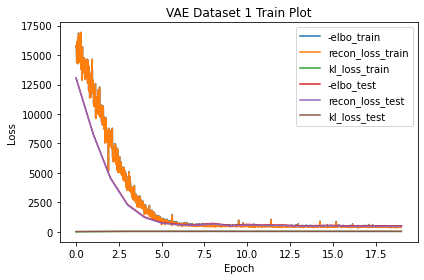

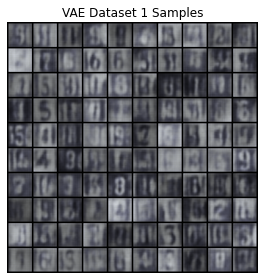

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


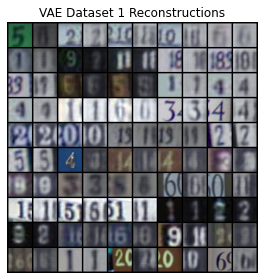

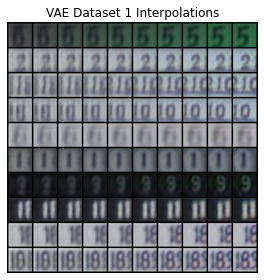

In [108]:
vae_save_results(1, problem_vae)

# Conditional VAE

In [1]:
%load_ext autoreload
%autoreload 2
from Cvae import *

  0%|          | 0/20 [00:00<?, ?it/s]

Final -ELBO: 436.1429, Recon Loss: 397.9991, KL Loss: 38.1438


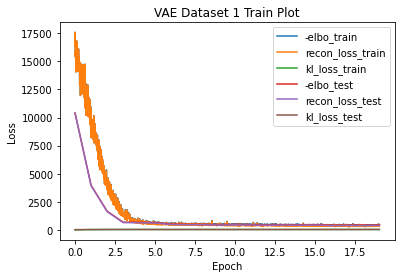

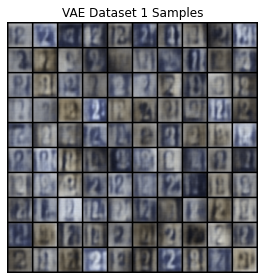

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


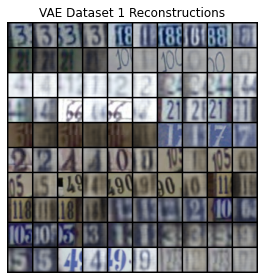

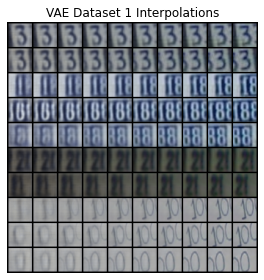

In [35]:
cvae_results(problem_cvae)

In [ ]:
import gc
gc.collect()

# GANs on CIFAR-10 (WGAN-GP with SN-GAN-like Architecture)

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

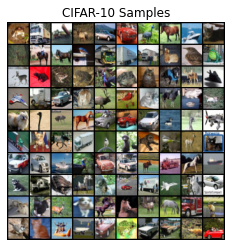

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from helpers_gan import visualize_cifar10_data

visualize_cifar10_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fr√©chet inception distance (bonus, 5pts) (in research papers people report both Inception score and FID)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from helpers_gan import visualize_cifar10_data

In [2]:
%load_ext autoreload
%autoreload 2
from GAN_depthspace import *

In [3]:
def gan(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    train_data, _ = utils.load_pickled_data('cifar10.pkl')
    train_data = train_data.transpose((0, 3, 1, 2)) / 255.0
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=True, drop_last=True)
    cuda = True if torch.cuda.is_available() else False
    lambda_gp = 10
    n_critic = 5
    generator = Generator()
    discriminator = Discriminator()

    generator.cuda()
    discriminator.cuda()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0, 0.9))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0, 0.9))
    Tensor = torch.cuda.FloatTensor 
    lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lambda epoch: 0.98**epoch)
    lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lambda epoch: 0.98**epoch)
    
    def compute_gradient_penalty(D, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN GP"""
        # Random weight term for interpolation between real and fake samples
        alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = D(interpolates)
        fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    loss_metric = []
    for epoch in tqdm(range(3)):
        loss_epoch = []
        for i, (imgs) in enumerate(train_loader):

            real_imgs = Variable(imgs.type(Tensor))
            optimizer_D.zero_grad()
            z = Variable(Tensor(np.random.normal(0, 1, (256, 128))))
            fake_imgs = generator(z)
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)

            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()
            optimizer_G.zero_grad()
            

            if i % n_critic == 0:

                fake_imgs = generator(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(fake_imgs)
                g_loss = -torch.mean(fake_validity)
                
                g_loss.backward()
                optimizer_G.step()
                loss_epoch.append(g_loss.item())
                # save fake_imgs.data
        loss_metric.append(np.mean(loss_epoch))
        lr_scheduler_G.step()
        lr_scheduler_D.step()
        
    def sample(num):
        z = Variable(Tensor(np.random.normal(0, 1, (num, 128))))
        generated_imgs = generator(z)
        return generated_imgs.permute(0, 2, 3, 1)
    
    root_model_path = os.path.join('saved_model', 'GAN_model.pt')
    model_dict = {'generator': generator.state_dict(), 'discriminator': discriminator.state_dict(),   \
                  'optimizer_G': optimizer_G.state_dict(), 'optimizer_D': optimizer_D.state_dict()}
    torch.save(model_dict, root_model_path)
    return np.array(loss_metric), sample(1000).cpu().detach().numpy()

In [4]:
#torch.cuda.empty_cache()
#os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb'
#torch.cuda.max_memory_allocated()

  0%|          | 0/100 [00:00<?, ?it/s]

..........Inception score: 7.178294


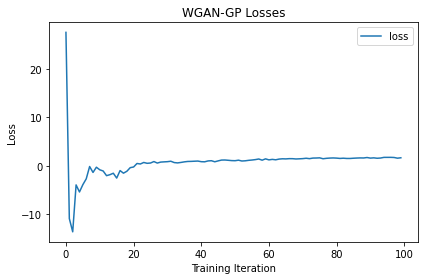

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


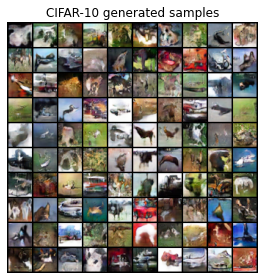

In [5]:
from helpers_gan import gan_save_results
gan_save_results(gan)

In [16]:
import gc
gc.collect()

21

In [10]:
from utils import *
train_data, _ = load_pickled_data('cifar10.pkl')
train_data = train_data.transpose((0, 3, 1, 2)) / 255.0

In [3]:
train_data.shape

(50000, 3, 32, 32)

In [4]:
25000 / (50000 / 256)

128.0

In [4]:
4*2048

8192

In [ ]:
from helpers_gan import gan_save_results
gan_save_results(gan)

# CycleGAN

In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

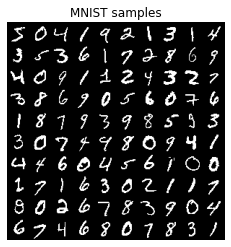

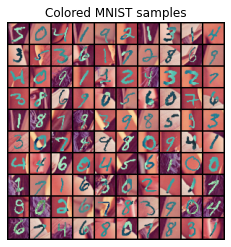

In [35]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from helpers_gan import visualize_cyclegan_datasets

visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [1]:
def cyclegan(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    device = torch.device('cuda')
    mnist, cmnist = torch.Tensor(mnist_data), torch.Tensor(cmnist_data)
    mnist = mnist.repeat(1, 3, 1, 1)
    train_ds = TensorDataset(mnist, cmnist)
    dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True)

    criterion_GAN = torch.nn.MSELoss().cuda()
    criterion_cycle = torch.nn.L1Loss().cuda()
    criterion_identity = torch.nn.L1Loss().cuda()

    input_shape = (3, 28, 28)
    opt = {'lr': 2e-4, 'b1': 0.5, 'b2':0.999, 'n_epochs': 25, 'epoch':0 , 'decay_epoch': 2, 
            'lambda_cyc': 10.0, 'lambda_id': 5.0}
    
    class Dict2Class(object):
        def __init__(self, my_dict):

            for key in my_dict:
                setattr(self, key, my_dict[key])
    opt = Dict2Class(opt)
    Tensor = torch.cuda.FloatTensor 
    # Initialize generator and discriminator
    G_XY = Generator(3).cuda()
    G_YX = Generator(3).cuda()
    D_X = Discriminator(input_shape).cuda()
    D_Y = Discriminator(input_shape).cuda()

    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    G_XY.apply(weights_init_normal)
    G_YX.apply(weights_init_normal)
    D_X.apply(weights_init_normal)
    D_Y.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(
        itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
    )
    optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
    optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
        
    class LambdaLR:
        def __init__(self, n_epochs, offset, decay_start_epoch):
            assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
            self.n_epochs = n_epochs
            self.offset = offset
            self.decay_start_epoch = decay_start_epoch

        def step(self, epoch):
            return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)
    
    # Learning rate update schedulers
    lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
        optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
    )
    lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_X, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
    )
    lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_Y, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
    )

    loss_G_metric = []
    loss_D_metric = []
    for epoch in tqdm(range(opt.epoch, opt.n_epochs)):
        loss_D_epoch = []
        loss_G_epoch = []
        for i, (x, y) in enumerate(dataloader):

            # Set model input
            real_X = Variable(x.type(Tensor))
            real_Y = Variable(y.type(Tensor))

            # Adversarial ground truths
            valid = Variable(Tensor(np.ones((real_X.size(0), *D_X.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((real_X.size(0), *D_X.output_shape))), requires_grad=False)

            # ------------------
            #  Train Generators
            # ------------------

            G_XY.train()
            G_YX.train()

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_X = criterion_identity(G_YX(real_X), real_X)
            loss_id_Y = criterion_identity(G_XY(real_Y), real_Y)

            loss_identity = (loss_id_X + loss_id_Y) / 2

            # GAN loss
            fake_Y = G_XY(real_X)
            loss_GAN_XY = criterion_GAN(D_Y(fake_Y), valid)
            fake_X = G_YX(real_Y)
            loss_GAN_YX = criterion_GAN(D_X(fake_X), valid)

            loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2

            # Cycle loss
            recov_X = G_YX(fake_Y)
            loss_cycle_X = criterion_cycle(recov_X, real_X)
            recov_Y = G_XY(fake_X)
            loss_cycle_Y = criterion_cycle(recov_Y, real_Y)

            loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

            # Total loss
            loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

            loss_G.backward()
            optimizer_G.step()
            loss_G_epoch.append(loss_G.item())
            # -----------------------
            #  Train Discriminator X
            # -----------------------

            optimizer_D_X.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_X(real_X), valid)
            loss_fake = criterion_GAN(D_X(fake_X.detach()), fake)
            # Total loss
            loss_D_X = (loss_real + loss_fake) / 2

            loss_D_X.backward()
            optimizer_D_X.step()

            # -----------------------
            #  Train Discriminator Y
            # -----------------------

            optimizer_D_Y.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_Y(real_Y), valid)
            loss_fake = criterion_GAN(D_Y(fake_Y.detach()), fake)
            # Total loss
            loss_D_Y = (loss_real + loss_fake) / 2

            loss_D_Y.backward()
            optimizer_D_Y.step()

            loss_D = (loss_D_X + loss_D_Y) / 2
            loss_D_epoch.append(loss_D.item())
        loss_G_metric.append(np.mean(loss_G_epoch))
        loss_D_metric.append(np.mean(loss_D_epoch))
        lr_scheduler_G.step()
        lr_scheduler_D_X.step()
        lr_scheduler_D_Y.step()

    plot_gan_training(loss_G_metric, 'CGAN-G Losses', 'results/cgan_g_losses.png')
    plot_gan_training(loss_D_metric, 'CGAN-D Losses', 'results/cgan_d_losses.png')

    valloader = DataLoader(train_ds, batch_size=1, shuffle=True, pin_memory=True)
    real_mnist = []
    trans_cmnist = []
    recov_mnist = []
    real_cmnist = []
    trans_mnist = []
    recov_cmnist = []

    for _ in range(20):
        x, y = next(iter(valloader))
        G_XY.eval()
        G_YX.eval()
        real_X = Variable(x.type(Tensor))
        fake_Y = G_XY(real_X)
        recov_X = G_YX(fake_Y)
        real_Y = Variable(y.type(Tensor))
        fake_X = G_YX(real_Y)
        recov_Y = G_XY(fake_X)

        real_mnist.append(x.squeeze(0).mean(0).unsqueeze(2).cpu().detach().numpy())
        trans_cmnist.append(fake_Y.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        recov_mnist.append(recov_X.squeeze(0).mean(0).unsqueeze(2).cpu().detach().numpy())
        real_cmnist.append(y.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        trans_mnist.append(fake_X.squeeze(0).mean(0).unsqueeze(2).cpu().detach().numpy())
        recov_cmnist.append(recov_Y.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

    return np.array(real_mnist), np.array(trans_cmnist), np.array(recov_mnist), \
                 np.array(real_cmnist), np.array(trans_mnist), np.array(recov_cmnist)
        

In [2]:
%load_ext autoreload
%autoreload 2
from CycleGAN import *
from helpers_gan import *

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\gordo\anaconda3\envs\cv37\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([256, 1, 1, 1])) that is different to the input size (torch.Size([256, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\gordo\anaconda3\envs\cv37\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([96, 1, 1, 1])) that is different to the input size (torch.Size([96, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


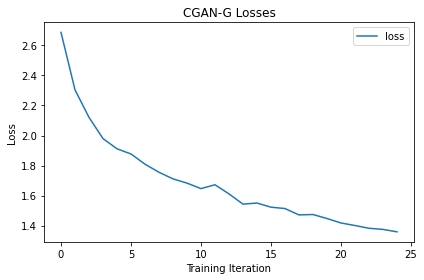

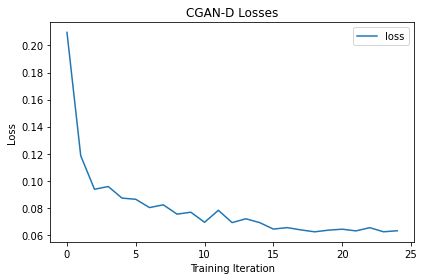

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


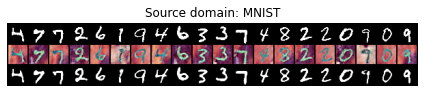

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


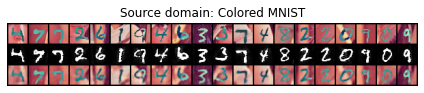

In [3]:
from helpers_gan import cyclegan_save_results
cyclegan_save_results(cyclegan)

In [7]:
opt = {'lr': 2e-4, 'b1': 0.5, 'b2':0.999, 'n_epochs': 3, 'epoch':0 , 'decay_epoch': 2, 
            'lambda_cyc': 10.0, 'lambda_id': 5.0}

In [21]:
mnist, cmnist = load_q4_data()
mnist, cmnist = torch.Tensor(mnist), torch.Tensor(cmnist)
mnist = mnist.repeat(1, 3, 1, 1)

In [6]:
28//2 **4

1

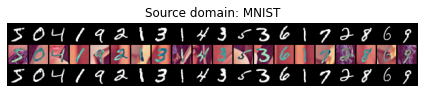

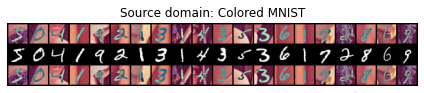

In [0]:
# Reference results